In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 데이터 분석
import os
import pickle
import zipfile
from collections import Counter
import pandas as pd

# 트랜스포머 모델 구조
import torch
import torch.nn as nn
from torch.nn import Transformer
from tqdm import tqdm

import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
data_path = r'/content/drive/MyDrive/sns_multimodal_sentiment_pr/multimodal_dataset' # 데이터셋 저장위치
file_path = r'/content/drive/MyDrive/sns_multimodal_sentiment_pr' # 프로젝트 파일 위치

In [ ]:
# GPU 사용 여부 확인 및 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 모달리티별 데이터셋 다운로드
## 비디오

### 비디오 파일 압축 해제

In [ ]:
#압축파일 다운로드용 poc 이후에 함수로 만들어서 깔끔하게 사용하자

# zip 파일 열기
with zipfile.ZipFile(data_path + r'/video_embeddings_with_labels_dataset.zip', 'r') as zip_ref:
    # 압축 파일 내의 파일 목록 가져오기
    file_list = zip_ref.namelist()

    # .m2ts 파일만 필터링
    video_files = [file for file in file_list if file.endswith('.pkl')]
    print(f"추출할 비디오-피클 파일 목록: {video_files}")

    # 비디오 파일을 저장할 폴더 생성
    extract_video_path = data_path + '//video_embeddings_with_labels_dataset'
    os.makedirs(extract_video_path, exist_ok=True)

    for video_file in video_files:
        zip_ref.extract(video_file, extract_video_path)
        print(f"{video_file} 파일을 추출했습니다.")

print("표정비디오 파일 추출이 완료되었습니다.")

In [ ]:
def load_all_pickles(directory):
    pickle_dict = {}
    plk_file_cnt = 0
    # 디렉토리 내의 모든 파일 탐색
    for filename in os.listdir(directory):
        if filename.endswith('.pkl'):
            filepath = os.path.join(directory, filename)
            filename = filename.split('_')[0].split('p')[1]
            # 피클 파일 로드
            with open(filepath, 'rb') as f:
                try:
                    data = pickle.load(f)
                    pickle_dict[filename] = data
                    plk_file_cnt += 1
                except (pickle.UnpicklingError, EOFError):
                    print(f"Error loading {filename}. Skipping this file.")

    return pickle_dict

# 사용 예시
video_data = load_all_pickles(data_path + '/video_embeddings_with_labels_dataset/final_embeddings_with_labels')

## 데이터 파악

In [ ]:
'''
video 데이터
삼중 딕셔너리 형식
key : 클립파일
value:  {key:프레임 번호 value: {key 'embedding','label' value:실제 임베딩벡터, 감정라벨} }

사용예시
all_video_pickles['850'][0]['label'] => 850번 비디오 파일에 0번 프레임의 감정라벨
all_video_pickles['850'][1]['embedding'] => 850번 비디오 파일에 1번 프레임의 768차원의 임베딩 벡터
'''
video_data['850'][0]['embedding'].shape

(768,)

In [ ]:
# 509개의 비디오 파일
len(video_data)

509

In [ ]:
def calculate_label_count(pickle_dict):
    label_counter = Counter()

    # 각 클립 파일에 대해 반복
    for clip, frames in pickle_dict.items():
        # 각 프레임에 대해 반복
        for frame, data in frames.items():
            if 'label' in data:
                label_counter[data['label']] += 1

    return label_counter

# 사용 예시
label_counts = calculate_label_count(video_data)

# 결과 출력
for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: 3, Count: 49782
Label: 1, Count: 73085
Label: 0, Count: 41708
Label: 4, Count: 35241
Label: 2, Count: 11596
Label: 5, Count: 24027


## 오디오
### .pt파일(임베딩 벡터) 와 .pkl파일(라벨파일) 이용
### 라벨인코더 학습된 라벨 : 학습된 라벨:  ['Anger' 'Disgust' 'Fear' 'Joy' 'Sad' 'Surprise']

In [ ]:
# CSV 파일 읽기
audio_csv_path = data_path + '/audio/audio_embeddings_with_labels.csv'  # CSV 파일 경로를 입력하세요
audio_csv = pd.read_csv(audio_csv_path)

# 데이터 확인 (상위 5개 행 출력)
print(audio_csv.tail())

       feature0   feature1   feature2   feature3   feature4   feature5  \
3440 -58.659317 -51.784115  52.293150  39.594425 -51.634136 -34.141113   
3441 -66.391685 -58.268600  59.215714  45.533780 -56.273182 -39.581055   
3442 -64.365830 -54.211853  55.036770  48.416466 -51.172886 -39.003790   
3443 -59.195960 -51.119140  51.954360  43.638165 -52.837620 -38.817528   
3444 -52.915615 -46.662487  50.691437  41.163307 -50.120620 -35.447388   

      feature6   feature7  feature8  feature9  ...  feature759  feature760  \
3440 -2.427839 -14.605315 -1.756148 -5.909170  ...  -70.441605   13.726962   
3441 -4.880929 -18.391668 -0.821934 -6.091936  ...  -79.488740   15.851904   
3442 -3.194179 -12.685541  0.435401 -6.084556  ...  -75.935800   16.499413   
3443 -2.694785 -12.124321 -2.260647 -4.181356  ...  -73.972380   12.483691   
3444 -4.412037 -11.780149 -2.176205 -6.656289  ...  -67.263160   11.297727   

      feature761  feature762  feature763  feature764  feature765  feature766  \
3440  

In [ ]:
audio_csv.shape # 한행이 하나의 데이터 한열이 하나의 차원 마지막열 감정라벨

(3445, 769)

In [ ]:
audio_csv['emotion_label'].value_counts()

,count
emotion_label,
3,1705
0,693
4,619
5,281
1,85
2,62


In [ ]:
# 전체 768차원 임베딩과 라벨 분리
audio_embeddings = torch.tensor(audio_csv.iloc[:, :-1].values, dtype=torch.float32)  # 768차원 임베딩
encoded_labels_tensor = torch.tensor(audio_csv['emotion_label'].values, dtype=torch.long)  # 감정 라벨

# 텐서의 형태 확인
print(audio_embeddings.shape)  # (3445, 768)
print(encoded_labels_tensor.shape)  # (3445,)

torch.Size([3445, 768])
torch.Size([3445])


## 텍스트

In [ ]:
# CSV 파일 읽기
text_file_path = data_path + '/text_embeddings_with_labels_kobert.csv'  # CSV 파일 경로를 입력하세요
text_data = pd.read_csv(text_file_path)

# 데이터 확인 (상위 5개 행 출력)
print(text_data.head())

   embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0     0.282235    -0.001824    -0.028005    -8.266879    -0.087873   
1     0.406004    -0.136235     0.151475    -6.331607     0.055239   
2     0.117374     0.125243     0.261748    -7.319091     0.208839   
3     0.261582     0.122135     0.029367    -8.301798    -0.016624   
4     0.326198     0.077952    -0.000108    -7.710666     0.042090   

   embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  ...  \
0    -0.002781    -0.150694     0.161355    -0.817538    -0.232642  ...   
1     0.149143    -0.062489     0.230630    -1.463283    -0.084049  ...   
2     0.084856    -0.083450     0.042545    -0.876277    -0.229047  ...   
3     0.055222    -0.059303     0.137835    -0.626130    -0.303440  ...   
4     0.154682    -0.049006     0.151745    -0.898616    -0.385771  ...   

   embedding_759  embedding_760  embedding_761  embedding_762  embedding_763  \
0      -0.125309       0.010383       0.115650  

### 데이터 파악

In [ ]:
text_data.shape

(103849, 769)

In [ ]:
text_data.describe()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767,emotion_label
count,103849.000000,103849.000000,103849.000000,103849.000000,103849.000000,103849.000000,103849.000000,103849.000000,103849.000000,103849.000000,...,103849.000000,103849.000000,103849.000000,103849.000000,103849.000000,103849.000000,103849.000000,103849.000000,103849.000000,103849.000000
mean,0.296722,0.003745,0.097043,-7.048025,0.038605,0.089866,-0.109904,0.108601,-0.985121,-0.190840,...,-0.123801,-0.036816,0.103862,0.017924,-0.355104,-0.164865,0.229294,-0.326351,-0.243494,2.535585
std,0.113769,0.113977,0.096665,1.096325,0.102619,0.078705,0.123311,0.111496,0.301565,0.137083,...,0.128774,0.100153,0.100155,0.117217,0.106748,0.164899,0.115966,0.108948,0.112202,1.792933
min,-0.389499,-0.668460,-0.310954,-10.032255,-0.560619,-0.420725,-0.671517,-0.673193,-2.138510,-0.670767,...,-0.682970,-0.602480,-0.656872,-0.586859,-1.100164,-0.803516,-0.503986,-0.762541,-0.767314,0.000000
25%,0.229150,-0.081978,0.031986,-7.934377,-0.006509,0.046206,-0.197521,0.061780,-1.197627,-0.303440,...,-0.200757,-0.084585,0.060389,-0.046417,-0.421748,-0.270335,0.173419,-0.378217,-0.328221,1.000000
50%,0.314676,0.026617,0.080355,-7.156435,0.042090,0.094411,-0.091594,0.133875,-0.904847,-0.191624,...,-0.139463,-0.040591,0.110962,0.004873,-0.337627,-0.183470,0.232738,-0.329457,-0.256385,3.000000
75%,0.374945,0.083771,0.151475,-6.331607,0.063854,0.138680,-0.027100,0.174416,-0.731074,-0.084049,...,-0.061316,0.013060,0.174584,0.102237,-0.275787,-0.094292,0.318268,-0.277711,-0.172404,4.000000
max,0.793972,0.397451,0.786993,0.138192,0.666872,0.515135,0.688970,0.760151,0.037334,0.644407,...,0.427174,0.761133,0.536436,0.546623,0.338989,0.354509,0.570784,0.535730,0.493046,5.000000


In [ ]:
text_data['emotion_label'].value_counts()

,count
emotion_label,
5,20567
0,19711
4,17367
2,15999
1,15799
3,14406


### 텍스트도 오디오 데이터와 동일하게 csv에서  트랜스포머 입력 임베딩과 라벨 텐서 추출

In [ ]:
# 전체 768차원 임베딩과 라벨 분리
text_embeddings = torch.tensor(text_data.iloc[:, :-1].values, dtype=torch.float32)  # 768차원 임베딩
encoded_text_labels_tensor = torch.tensor(text_data['emotion_label'].values, dtype=torch.long)  # 감정 라벨

# 텐서의 형태 확인
print(text_embeddings.shape)  # (3445, 768)
print(encoded_text_labels_tensor.shape)  # (3445,)

torch.Size([103849, 768])
torch.Size([103849])


## 이미지

In [ ]:
# CSV 파일 읽기
image_file_path = data_path + '/image_embeddings_with_labels_768.csv'  # CSV 파일 경로를 입력하세요
image_data = pd.read_csv(image_file_path)

# 데이터 확인 (상위 5개 행 출력)
print(image_data.head())

   embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0     0.676258     0.126480     0.011349     0.337497     0.381315   
1     0.640228     0.648514     0.304709    -0.076483     0.643950   
2     0.375265     0.569587     0.001503    -0.017520     0.510857   
3     0.684450     0.323732    -0.102422     0.157018     0.516019   
4     0.077913     0.088050    -0.094371     0.117026     0.560978   

   embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  ...  \
0     0.131017     0.067836     0.390246    -0.213228    -0.452141  ...   
1    -0.033903     0.756811     0.275337    -0.127085    -0.072901  ...   
2     0.099864     0.584011     0.582919     0.109880     0.127415  ...   
3    -0.037848     0.247245     0.502890     0.115673     0.054178  ...   
4    -0.032629     0.050611     0.386414    -0.193570     0.228703  ...   

   embedding_759  embedding_760  embedding_761  embedding_762  embedding_763  \
0       0.225760       0.196282       0.042231  

### 데이터 파악

In [ ]:
image_data.shape

(1980, 769)

In [ ]:
image_data.describe()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767,emotion_label
count,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,...,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000
mean,0.020606,0.000852,-0.005459,-0.003526,0.019617,-0.001209,-0.011376,-0.005932,0.009968,-0.009872,...,-0.029361,-0.020921,-0.020319,0.009399,0.017212,-0.014874,-0.025321,0.019332,0.017479,2.500000
std,0.314057,0.333236,0.325118,0.309469,0.348320,0.346621,0.332799,0.291971,0.326585,0.324545,...,0.333621,0.335565,0.339771,0.352838,0.322827,0.342397,0.326208,0.323025,0.342935,1.708257
min,-1.091884,-0.998439,-1.063059,-1.242696,-1.077222,-1.155611,-1.207635,-1.021483,-1.151230,-1.082255,...,-1.158044,-1.518431,-1.129370,-1.410665,-0.968830,-1.453961,-1.462829,-1.001828,-1.378061,0.000000
25%,-0.181673,-0.206478,-0.230732,-0.204452,-0.215199,-0.237859,-0.234011,-0.207113,-0.199757,-0.219114,...,-0.249479,-0.253948,-0.234156,-0.228284,-0.194873,-0.238162,-0.235841,-0.195948,-0.204717,1.000000
50%,0.018233,-0.002660,-0.008962,-0.003990,0.017419,0.001007,-0.015671,-0.013412,0.016377,-0.009242,...,-0.023900,-0.026007,-0.018559,0.017679,0.016155,-0.020514,-0.031783,0.005819,0.025962,2.500000
75%,0.241367,0.213127,0.222879,0.190131,0.253128,0.238733,0.216653,0.196464,0.220682,0.216033,...,0.196413,0.213677,0.211945,0.246683,0.231281,0.214075,0.183876,0.227027,0.242889,4.000000
max,1.011252,1.210432,1.111023,1.301837,1.165544,1.005549,0.974377,0.959645,1.449360,0.980307,...,1.083446,0.987914,1.099598,1.330509,1.475140,1.507157,1.062148,1.276900,1.277132,5.000000


In [ ]:
image_data['emotion_label'].value_counts()

,count
emotion_label,
0,330
1,330
2,330
3,330
4,330
5,330


________________________________

In [ ]:
# 전체 768차원 임베딩과 라벨 분리
image_embeddings = torch.tensor(image_data.iloc[:, :-1].values, dtype=torch.float32)  # 768차원 임베딩
encoded_image_labels_tensor = torch.tensor(image_data['emotion_label'].values, dtype=torch.long)  # 감정 라벨

# 텐서의 형태 확인
print(image_embeddings.shape)  # (1980, 768)
print(encoded_image_labels_tensor.shape)  # (1980,)

torch.Size([1980, 768])
torch.Size([1980])


# 트랜스포머 모델 구조
## 각자 데이터 별로 처리해줘야 할 사항들이 있는지 체크해보자
### 비디오: 시간정보 살리기 위해서 프레임 번호 순서대로 진행되게 하기 필수
### 오디오: 마찬가지로 시간정보 체크
### 텍스트&이미지: 성능 향상 목표  

In [ ]:
# 공통 트랜스포머 모델 구조
def add_cls_token_and_positional_embedding(input_embeddings, pos_embedding, cls_token, frame_numbers=None, apply_pos_embedding=True):
    """
    input_embeddings: (batch_size, seq_len, embed_dim) 또는 (batch_size, embed_dim)
    pos_embedding: (max_seq_len + 1, embed_dim) - 포지셔널 임베딩
    cls_token: (1, 1, embed_dim) - CLS 토큰
    frame_numbers: (batch_size, seq_len) - 각 프레임의 번호 (포지셔널 임베딩에 사용)
    apply_pos_embedding: 포지셔널 임베딩을 적용할지 여부 (오디오 및 텍스트 모달리티에서는 False)
    """
    if len(input_embeddings.shape) == 2:  # 입력이 (batch_size, embed_dim)인 경우
        batch_size, embed_dim = input_embeddings.shape
        seq_len = 1  # sequence 길이를 1로 설정
        input_embeddings = input_embeddings.unsqueeze(1)  # (batch_size, 1, embed_dim)로 변환
    else:  # 입력이 (batch_size, seq_len, embed_dim)인 경우
        batch_size, seq_len, embed_dim = input_embeddings.shape

    # [CLS] 토큰 추가
    cls_tokens = cls_token.expand(batch_size, 1, embed_dim)  # (batch_size, 1, embed_dim)
    input_embeddings = torch.cat((cls_tokens, input_embeddings), dim=1)  # (batch_size, seq_len + 1, embed_dim)

    if apply_pos_embedding:
        # 프레임 번호가 있을 경우 해당 포지션 사용
        if frame_numbers is not None:
            pos_embeddings = pos_embedding[frame_numbers]  # (batch_size, seq_len, embed_dim)
            pos_embeddings = torch.cat([pos_embedding[0].unsqueeze(0).repeat(batch_size, 1, 1), pos_embeddings], dim=1)  # CLS 토큰 포함
        else:
            # 프레임 번호가 없으면 순차적으로 포지셔널 임베딩 추가
            pos_embeddings = pos_embedding[:seq_len + 1].unsqueeze(0).repeat(batch_size, 1, 1)  # (batch_size, seq_len + 1, embed_dim)

        # 임베딩에 포지셔널 임베딩을 더함
        input_embeddings += pos_embeddings

    return input_embeddings

In [ ]:
# 모달리티별 트랜스포머 모델 (포지셔널 임베딩 필요 여부 적용)
class ModalityTransformerWithCLSAndFramewisePrediction(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8, num_layers=6, max_seq_len=1000):
        super(ModalityTransformerWithCLSAndFramewisePrediction, self).__init__()

        # Transformer Encoder 설정
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # [CLS] 토큰과 포지셔널 임베딩 초기화
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))  # [CLS] 토큰
        self.pos_embedding = nn.Parameter(torch.randn(max_seq_len + 1, embed_dim))  # CLS 포함한 포지셔널 임베딩

        # 분류기 (감정 라벨이 6개로 수정)
        self.classifier = nn.Linear(embed_dim, 6)  # 감정 라벨이 6개 (0, 1, 2, 3, 4, 5)

    def forward(self, input_embeddings, modality, frame_numbers=None):
        """
        modality: 'video', 'image', 'audio', 'text'에 따라 포지셔널 임베딩 여부 결정
        frame_numbers: 비디오 모달리티에서 프레임 번호가 제공됨
        """
        # 모달리티에 따른 포지셔널 임베딩 적용 여부 설정
        if modality in ['video', 'image']:
            apply_pos_embedding = True  # 비디오와 이미지 모달리티는 포지셔널 임베딩 필요
        else:
            apply_pos_embedding = False  # 오디오와 텍스트는 이미 포지셔널 임베딩이 포함됨

        # [CLS] 토큰과 포지셔널 임베딩 추가
        input_embeddings = add_cls_token_and_positional_embedding(
            input_embeddings, self.pos_embedding, self.cls_token, frame_numbers, apply_pos_embedding)

        # Transformer 통과 (CLS 토큰 포함)
        transformer_output = self.transformer(input_embeddings)  # (batch_size, seq_len + 1, embed_dim)

        # [CLS] 토큰은 전체 비디오 시퀀스의 요약 정보로 사용
        cls_output = transformer_output[:, 0, :]  # (batch_size, embed_dim)

        # 프레임별로 감정 예측 (모달리티에 따라 적용)
        if modality == 'video':
            framewise_output = self.classifier(transformer_output[:, 1:, :])  # (batch_size, seq_len, 6)
            return cls_output, framewise_output
        else:
            # 다른 모달리티에서는 framewise_output을 반환하지 않고 CLS 토큰만 반환
            return cls_output

In [ ]:
# EarlyStopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        patience: 성능이 개선되지 않아도 기다릴 최대 횟수
        min_delta: 성능이 개선되었다고 간주되는 최소한의 변화량
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0


# 비디오 트랜스포머 아웃풋
- 비디오 시간적정보 및 포지셔널 임베딩 처리 필요
## 평가 후 best 모델 저장해 교차학습을 위한 임베딩 벡터 추출

In [ ]:
## max_seq_len을 체크하기 위한 비디오프레임 최대개수 체크
max_frames = max(len(frames) for frames in video_data.values())
print(f"최대 프레임 개수: {max_frames}")

# 1500으로 하자 용량 감당 안되면 1000

최대 프레임 개수: 2864


In [ ]:
video_data['850'][0]

{'embedding': array([ 6.70589626e-01,  8.02716166e-02, -2.65618503e-01,  2.51852721e-01,
         9.11679640e-02, -8.69118422e-03,  5.35325646e-01, -2.28303969e-01,
         1.68833897e-01,  1.10582925e-01, -2.60048360e-01,  1.03890896e-04,
         2.24917069e-01,  3.43664467e-01,  3.05540025e-01,  2.98092775e-02,
         1.75998822e-01,  6.74159348e-01, -3.45690012e-01,  6.67209551e-02,
         9.88307223e-02,  2.10513979e-01,  1.51059732e-01,  5.70796616e-02,
        -3.98473367e-02,  1.25657052e-01,  1.08115189e-01, -2.25538351e-02,
        -1.88701376e-01, -6.05168082e-02, -5.80158412e-01,  6.09871566e-01,
        -4.26485240e-02,  4.93077397e-01,  3.51556242e-02,  6.42179966e-01,
        -2.48421788e-01, -9.32389498e-02, -1.99256510e-01,  3.06112796e-01,
        -1.30451191e-02,  1.49121419e-01, -4.17200655e-01,  1.14452064e-01,
        -3.37221175e-01,  2.32110079e-02, -2.38572493e-01,  2.55362004e-01,
        -2.58727103e-01, -3.02703887e-01, -2.92155594e-01, -2.75442004e-01,

In [ ]:
import torch
import numpy as np

def process_video_data(video_data, max_seq_len, embed_dim=768, padding_value=0):
    embedding_vectors = []
    frame_numbers = []
    emotion_labels = []

    for clip_id, frames in video_data.items():
        clip_embeddings = []
        clip_labels = []
        clip_frame_numbers = []

        for frame_number, frame_data in frames.items():
            # 각 프레임의 임베딩 벡터와 감정 라벨 추출
            clip_embeddings.append(frame_data['embedding'])

            # 문자열 라벨을 정수형으로 변환
            clip_labels.append(int(frame_data['label']))

            clip_frame_numbers.append(frame_number)

        # 프레임 수가 max_seq_len보다 클 경우, max_seq_len까지만 잘라냄
        if len(clip_embeddings) > max_seq_len:
            clip_embeddings = clip_embeddings[:max_seq_len]
            clip_labels = clip_labels[:max_seq_len]
            clip_frame_numbers = clip_frame_numbers[:max_seq_len]
        else:
            # 부족한 프레임 수만큼 패딩 (임베딩 벡터는 0으로, 프레임 번호는 0으로 패딩)
            padding_size = max_seq_len - len(clip_embeddings)
            clip_embeddings += [[padding_value] * embed_dim] * padding_size
            clip_frame_numbers += [0] * padding_size
            clip_labels += [0] * padding_size  # 감정 라벨 패딩 (0을 기본값으로 처리)

        embedding_vectors.append(clip_embeddings)
        frame_numbers.append(clip_frame_numbers)
        emotion_labels.append(clip_labels)  # 모든 프레임에 대해 감정 라벨 저장

    # 텐서로 변환 (라벨도 시퀀스 차원을 유지)
    embedding_vectors = torch.tensor(embedding_vectors, dtype=torch.float32)  # (num_clips, max_seq_len, embed_dim)
    frame_numbers = torch.tensor(frame_numbers, dtype=torch.long)  # (num_clips, max_seq_len)
    emotion_labels = torch.tensor(emotion_labels, dtype=torch.long)  # (num_clips, max_seq_len)

    return embedding_vectors, frame_numbers, emotion_labels

In [ ]:
# 학습 파라미터 설정
embed_dim = 768
max_seq_len = 3000  # 시퀀스 길이를 설정 (입력의 최대 프레임 수)
num_epochs = 20
batch_size = 4
learning_rate = 1e-4

In [ ]:
# 비디오데이터에서 임베딩 벡터, 프레임넘버, 라벨 추출
embedding_vectors, frame_numbers, emotion_labels = process_video_data(video_data, max_seq_len)

# embedding_vectors 리스트를 numpy 배열로 먼저 변환한 후 PyTorch tensor로 변환
embedding_vectors = np.array(embedding_vectors)  # 리스트를 numpy 배열로 변환
embedding_vectors = torch.tensor(embedding_vectors, dtype=torch.float32)  # numpy 배열을 tensor로 변환

# frame_numbers와 emotion_labels도 동일하게 처리 (필요한 경우)
frame_numbers = np.array(frame_numbers)  # numpy 배열로 변환
frame_numbers = torch.tensor(frame_numbers, dtype=torch.float32)  # tensor로 변환

emotion_labels = np.array(emotion_labels)  # numpy 배열로 변환
emotion_labels = torch.tensor(emotion_labels, dtype=torch.float32)  # tensor로 변환

# 결과 출력
print(embedding_vectors.shape)  # (num_clips, max_seq_len, embed_dim) (비디오 개수, 최대 프레임 길이, 임베딩 차원)
print(frame_numbers.shape)  # (num_clips, max_seq_len)
print(emotion_labels.shape)  # (num_clips, emotion_label)

<ipython-input-36-055eea0e9b69>:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  embedding_vectors = torch.tensor(embedding_vectors, dtype=torch.float32)  # (num_clips, max_seq_len, embed_dim)


torch.Size([509, 3000, 768])
torch.Size([509, 3000])
torch.Size([509, 3000])


# 모델 학습 및 성능 시각화

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 10%|█         | 1/10 [00:14<02:07, 14.14s/it]

Epoch [1/10], Train Loss: 0.8655, Val Loss: 0.3163, Train Acc: 0.6977, Val Acc: 0.8760


 20%|██        | 2/10 [00:28<01:53, 14.24s/it]

Epoch [2/10], Train Loss: 0.6224, Val Loss: 0.3819, Train Acc: 0.7358, Val Acc: 0.8642


 30%|███       | 3/10 [00:42<01:40, 14.33s/it]

Epoch [3/10], Train Loss: 0.6246, Val Loss: 0.3292, Train Acc: 0.7394, Val Acc: 0.8697


 40%|████      | 4/10 [00:57<01:26, 14.39s/it]

Epoch [4/10], Train Loss: 0.6151, Val Loss: 0.2671, Train Acc: 0.7269, Val Acc: 0.9012


 50%|█████     | 5/10 [01:11<01:11, 14.37s/it]

Epoch [5/10], Train Loss: 0.6283, Val Loss: 0.2984, Train Acc: 0.7367, Val Acc: 0.8758


 60%|██████    | 6/10 [01:25<00:57, 14.34s/it]

Epoch [6/10], Train Loss: 0.6027, Val Loss: 0.2920, Train Acc: 0.7444, Val Acc: 0.8657


 70%|███████   | 7/10 [01:40<00:42, 14.32s/it]

Epoch [7/10], Train Loss: 0.5956, Val Loss: 0.2976, Train Acc: 0.7393, Val Acc: 0.8991


 80%|████████  | 8/10 [01:54<00:28, 14.31s/it]

Epoch [8/10], Train Loss: 0.6202, Val Loss: 0.3143, Train Acc: 0.7416, Val Acc: 0.8647


 80%|████████  | 8/10 [02:08<00:32, 16.11s/it]

Epoch [9/10], Train Loss: 0.6081, Val Loss: 0.3242, Train Acc: 0.7422, Val Acc: 0.8638
Early stopping at epoch 9


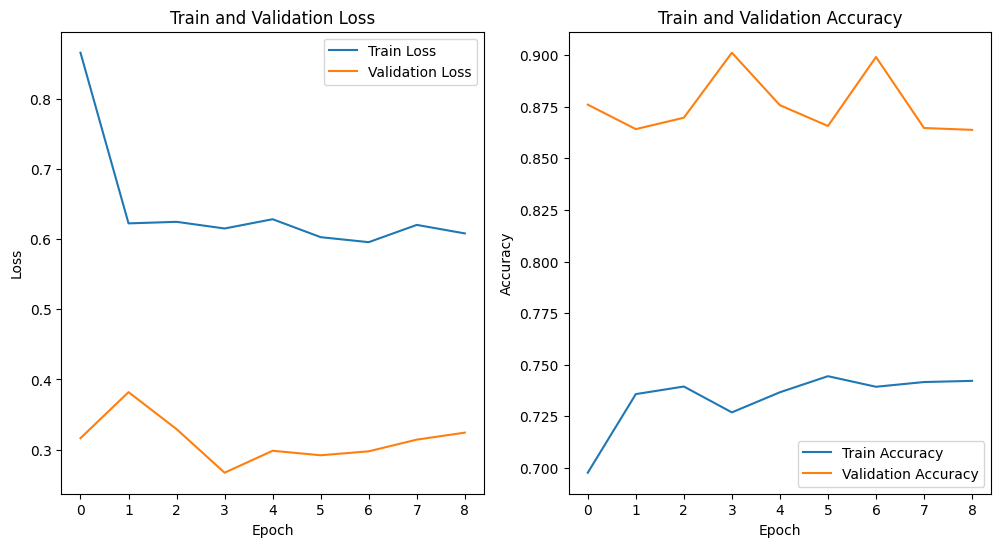

Final Accuracy: 0.8638
Final F1 Score: 0.8618


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

# 모델, 손실 함수, 옵티마이저 설정
model = ModalityTransformerWithCLSAndFramewisePrediction(embed_dim=embed_dim, num_heads=8, num_layers=6, max_seq_len=max_seq_len).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 데이터 나누기 (80:20 비율로 학습/테스트 데이터 나눔)
num_samples = embedding_vectors.size(0)
train_size = int(0.8 * num_samples)

train_embeddings = embedding_vectors[:train_size]
train_frame_numbers = frame_numbers[:train_size]
train_labels = emotion_labels[:train_size]

test_embeddings = embedding_vectors[train_size:]
test_frame_numbers = frame_numbers[train_size:]
test_labels = emotion_labels[train_size:]

# 데이터 배치 처리를 위한 DataLoader 생성
train_data = torch.utils.data.TensorDataset(train_embeddings, train_frame_numbers, train_labels)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)

test_data = torch.utils.data.TensorDataset(test_embeddings, test_frame_numbers, test_labels)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

# EarlyStopping 인스턴스 생성
early_stopping = EarlyStopping(patience=5)

# 성능 기록을 위한 리스트 초기화
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epoch_cnt = 0
# 학습 루프 (CLS 토큰 및 프레임별 감정 예측 포함)
for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0

    correct_preds, total_preds = 0, 0  # 매 에폭마다 초기화

    for batch_embeddings, batch_frame_numbers, batch_labels in train_loader:
        # 데이터를 GPU로 이동
        batch_embeddings, batch_frame_numbers, batch_labels = batch_embeddings.to(device), batch_frame_numbers.to(device), batch_labels.to(device)

        # batch_labels와 batch_frame_numbers를 long 타입으로 변환
        batch_labels = batch_labels.long()
        batch_frame_numbers = batch_frame_numbers.long()

        # Forward pass: CLS 토큰과 각 프레임의 감정 예측
        cls_output, framewise_output = model(batch_embeddings, modality='video', frame_numbers=batch_frame_numbers)

        # 출력과 라벨의 차원을 맞추기 위해 view 사용
        framewise_output = framewise_output.view(-1, framewise_output.size(-1))  # (batch_size * seq_len, num_classes)
        batch_labels = batch_labels.view(-1)  # (batch_size * seq_len)

        # 손실 함수 계산
        loss = criterion(framewise_output, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 정확도 계산
        _, predicted = torch.max(framewise_output, 1)
        correct_preds += (predicted == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    # 학습 손실 및 정확도 기록
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = correct_preds / total_preds
    train_accuracies.append(train_accuracy)

    # 검증 단계
    model.eval()
    val_loss = 0
    correct_preds, total_preds = 0, 0  # 검증 단계에서 다시 초기화
    with torch.no_grad():
        for batch_embeddings, batch_frame_numbers, batch_labels in test_loader:
            batch_embeddings, batch_frame_numbers, batch_labels = batch_embeddings.to(device), batch_frame_numbers.to(device), batch_labels.to(device)

            # batch_labels와 batch_frame_numbers를 long 타입으로 변환
            batch_labels = batch_labels.long()
            batch_frame_numbers = batch_frame_numbers.long()

            # Forward pass (검증)
            cls_output, framewise_output = model(batch_embeddings, modality='video', frame_numbers=batch_frame_numbers)

            framewise_output = framewise_output.view(-1, framewise_output.size(-1))  # (batch_size * seq_len, num_classes)
            batch_labels = batch_labels.view(-1)  # (batch_size * seq_len)

            val_loss += criterion(framewise_output, batch_labels).item()

            # 검증 정확도 계산
            _, predicted = torch.max(framewise_output, 1)
            correct_preds += (predicted == batch_labels).sum().item()
            total_preds += batch_labels.size(0)

    # 검증 손실 및 정확도 기록
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    val_accuracy = correct_preds / total_preds
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    epoch_cnt += 1
    # Early stopping 체크
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

# 성능 시각화
plt.figure(figsize=(12, 6))

# 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy")
plt.legend()

plt.show()

# 성능 평가 루프 (프레임별 감정 예측 평가)
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_embeddings, batch_frame_numbers, batch_labels in test_loader:
        # 데이터를 GPU로 이동
        batch_embeddings, batch_frame_numbers, batch_labels = batch_embeddings.to(device), batch_frame_numbers.to(device), batch_labels.to(device)

        # batch_frame_numbers와 batch_labels를 long 타입으로 변환
        batch_frame_numbers = batch_frame_numbers.long()
        batch_labels = batch_labels.long()

        # Forward pass (batch_frame_numbers는 long 타입이어야 함)
        cls_output, framewise_output =  model(batch_embeddings, modality='video', frame_numbers=batch_frame_numbers)

        # 출력과 라벨의 차원 맞추기
        framewise_output = framewise_output.view(-1, framewise_output.size(-1))

        # 예측값 predicted를 long 타입으로 변환
        _, predicted = torch.max(framewise_output, 1)
        predicted = predicted.long()

        batch_labels = batch_labels.view(-1)

        # GPU 텐서를 CPU로 이동하여 numpy로 변환
        all_preds.extend(predicted.cpu().numpy())  # GPU 텐서를 CPU로 변환 후 numpy로 변환
        all_labels.extend(batch_labels.cpu().numpy())  # 동일하게 처리

# 정확도 및 F1 점수 계산
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

# 모델 저장 (확장자 추가)
torch.save(model.state_dict(), file_path + f'/individual_modality_transformer_model/video_epoch_{epoch_cnt}_acc_{accuracy:.3f}.pth')

print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final F1 Score: {f1:.4f}")

# 모델 로드

In [ ]:
model = ModalityTransformerWithCLSAndFramewisePrediction(embed_dim=embed_dim, num_heads=8, num_layers=6, max_seq_len=max_seq_len).to(device)
model.load_state_dict(torch.load(file_path + '/individual_modality_transformer_model/video_epoch_9_acc_0.957.pth'))
model.eval()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
<ipython-input-38-06e3b7558cf8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless th

ModalityTransformerWithCLSAndFramewisePrediction(
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=768, out_features=6, bias=True)
)

## 교차학습을 위한 비디오 임베딩 데이터 저장

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# 먼저 비디오 데이터를 TensorDataset으로 묶기
video_dataset = TensorDataset(embedding_vectors, frame_numbers, emotion_labels)

# DataLoader 생성 (배치 크기 16, 셔플 여부는 필요에 따라 설정)
video_loader = DataLoader(video_dataset, batch_size=4, shuffle=False, drop_last=True)

In [ ]:
video_embeddings = []

# 모델을 평가 모드로 설정
model.eval()

with torch.no_grad():
    for batch_embeddings, batch_frame_numbers, batch_labels in video_loader:  # 세 개의 값 추출 (임베딩, 프레임 번호, 라벨)
        batch_embeddings, batch_frame_numbers = batch_embeddings.to(device), batch_frame_numbers.to(device)

        # batch_labels와 batch_frame_numbers를 long 타입으로 변환
        batch_labels = batch_labels.long()
        batch_frame_numbers = batch_frame_numbers.long()

        # 모델에 비디오 데이터를 입력하고 CLS 토큰 또는 프레임별 출력값 추출
        cls_output, _ = model(batch_embeddings, batch_frame_numbers)


        # CLS 토큰을 임베딩으로 사용 (필요에 따라 framewise_output도 사용 가능)
        video_embeddings.append(cls_output.cpu().numpy())

# 리스트를 numpy 배열로 변환
video_embeddings = np.array(video_embeddings)

In [ ]:
np.save(file_path + '/contrastive_learning_input_embedding/video_embeddings.npy', video_embeddings)

In [ ]:
# 저장된 비디오 임베딩 데이터를 불러오기
video_embeddings = np.load('/content/drive/MyDrive/sns_multimodal_sentiment_pr/contrastive_learning_input_embedding/video_embeddings.npy')

# 데이터의 형태를 확인
print(video_embeddings.shape)

# 127개 비디오 클립 4개 프레임 768차원 drap last 는 트루로 남은건 버리고 배치사이즈 4로 비디오 4개씩 묶어서 127개 파일 768차원 임베딩 벡터

(127, 4, 768)


# 오디오 트랜스포머 아웃풋
## 오디오는 포지셔널 임베딩 이미 돼있으므로 cls 토큰만 추가
### 강룡님 말 참고해서 정리하기


In [ ]:
encoded_labels_tensor.shape, audio_embeddings.shape

(torch.Size([3445]), torch.Size([3445, 768]))

## 모델 학습 및 성능 시각화

In [ ]:
# 2. DataLoader 준비 (입력과 라벨을 묶어서 제공)
batch_size = 32
dataset = TensorDataset(audio_embeddings, encoded_labels_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
import numpy as np

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  3%|▎         | 1/30 [00:03<01:35,  3.28s/it]

Epoch [1/30], Predicted Values: [3 3 3 3 3 3 3 3 3 4]
Epoch [1/30], Actual Labels: [3 4 4 0 4 4 3 3 4 4]
Epoch [1/30], Train Loss: 2.2015, Val Loss: 1.4901, Train Acc: 0.4029, Val Acc: 0.5101


  7%|▋         | 2/30 [00:05<01:19,  2.83s/it]

Epoch [2/30], Predicted Values: [0 3 4 3 3 3 3 0 0 3]
Epoch [2/30], Actual Labels: [4 3 3 5 3 2 4 3 0 0]
Epoch [2/30], Train Loss: 1.6469, Val Loss: 1.4649, Train Acc: 0.4139, Val Acc: 0.5101


 10%|█         | 3/30 [00:08<01:10,  2.61s/it]

Epoch [3/30], Predicted Values: [3 0 3 3 3 3 3 3 3 3]
Epoch [3/30], Actual Labels: [4 0 0 1 3 4 4 3 4 5]
Epoch [3/30], Train Loss: 1.6388, Val Loss: 1.4814, Train Acc: 0.4000, Val Acc: 0.5101


 13%|█▎        | 4/30 [00:10<01:05,  2.51s/it]

Epoch [4/30], Predicted Values: [3 3 0 3 0 3 3 3 3 3]
Epoch [4/30], Actual Labels: [3 4 3 3 4 0 0 3 0 3]
Epoch [4/30], Train Loss: 1.5748, Val Loss: 1.4297, Train Acc: 0.4287, Val Acc: 0.5101


 17%|█▋        | 5/30 [00:12<01:01,  2.45s/it]

Epoch [5/30], Predicted Values: [0 3 0 3 3 0 3 3 0 0]
Epoch [5/30], Actual Labels: [4 3 4 0 5 4 3 3 3 0]
Epoch [5/30], Train Loss: 1.5853, Val Loss: 1.4616, Train Acc: 0.4200, Val Acc: 0.5101


 20%|██        | 6/30 [00:15<00:58,  2.42s/it]

Epoch [6/30], Predicted Values: [0 3 3 0 3 3 3 3 3 3]
Epoch [6/30], Actual Labels: [3 4 3 0 3 5 3 0 3 3]
Epoch [6/30], Train Loss: 1.5352, Val Loss: 1.4732, Train Acc: 0.4316, Val Acc: 0.5101


 23%|██▎       | 7/30 [00:17<00:55,  2.39s/it]

Epoch [7/30], Predicted Values: [3 3 0 3 3 3 3 3 4 3]
Epoch [7/30], Actual Labels: [0 3 3 3 3 0 0 3 3 4]
Epoch [7/30], Train Loss: 1.5269, Val Loss: 1.4341, Train Acc: 0.4355, Val Acc: 0.5101


 27%|██▋       | 8/30 [00:19<00:52,  2.37s/it]

Epoch [8/30], Predicted Values: [3 3 3 3 3 3 3 3 3 3]
Epoch [8/30], Actual Labels: [3 5 0 1 5 3 0 0 0 3]
Epoch [8/30], Train Loss: 1.5297, Val Loss: 1.4551, Train Acc: 0.4387, Val Acc: 0.5101


 30%|███       | 9/30 [00:22<00:50,  2.38s/it]

Epoch [9/30], Predicted Values: [3 3 3 4 3 3 3 0 3 3]
Epoch [9/30], Actual Labels: [3 0 3 0 3 0 4 2 3 3]
Epoch [9/30], Train Loss: 1.5134, Val Loss: 1.4502, Train Acc: 0.4390, Val Acc: 0.5101


 33%|███▎      | 10/30 [00:24<00:47,  2.36s/it]

Epoch [10/30], Predicted Values: [3 4 3 3 3 3 4 3 3 3]
Epoch [10/30], Actual Labels: [0 3 3 3 3 3 3 3 3 3]
Epoch [10/30], Train Loss: 1.4904, Val Loss: 1.4020, Train Acc: 0.4432, Val Acc: 0.5101


 37%|███▋      | 11/30 [00:26<00:44,  2.35s/it]

Epoch [11/30], Predicted Values: [0 3 4 3 3 3 3 3 3 3]
Epoch [11/30], Actual Labels: [3 2 3 3 3 5 4 3 3 3]
Epoch [11/30], Train Loss: 1.4873, Val Loss: 1.4254, Train Acc: 0.4455, Val Acc: 0.5101


 40%|████      | 12/30 [00:29<00:42,  2.35s/it]

Epoch [12/30], Predicted Values: [0 4 3 3 3 0 3 0 4 4]
Epoch [12/30], Actual Labels: [3 3 0 0 4 3 0 3 3 3]
Epoch [12/30], Train Loss: 1.4854, Val Loss: 1.4838, Train Acc: 0.4390, Val Acc: 0.5101


 43%|████▎     | 13/30 [00:31<00:39,  2.35s/it]

Epoch [13/30], Predicted Values: [3 3 3 3 3 0 3 3 3 3]
Epoch [13/30], Actual Labels: [4 3 4 0 5 3 3 5 0 3]
Epoch [13/30], Train Loss: 1.4806, Val Loss: 1.4325, Train Acc: 0.4523, Val Acc: 0.5101


 47%|████▋     | 14/30 [00:33<00:37,  2.33s/it]

Epoch [14/30], Predicted Values: [3 0 0 0 0 3 4 3 3 3]
Epoch [14/30], Actual Labels: [4 0 3 0 3 3 3 1 3 0]
Epoch [14/30], Train Loss: 1.4730, Val Loss: 1.4207, Train Acc: 0.4510, Val Acc: 0.5101


 50%|█████     | 15/30 [00:36<00:35,  2.34s/it]

Epoch [15/30], Predicted Values: [3 3 3 3 3 0 3 0 0 3]
Epoch [15/30], Actual Labels: [3 4 2 3 1 0 3 3 4 3]
Epoch [15/30], Train Loss: 1.4736, Val Loss: 1.6022, Train Acc: 0.4574, Val Acc: 0.5101


 53%|█████▎    | 16/30 [00:38<00:32,  2.34s/it]

Epoch [16/30], Predicted Values: [3 3 0 3 3 3 3 3 3 3]
Epoch [16/30], Actual Labels: [3 3 0 4 3 0 1 0 3 3]
Epoch [16/30], Train Loss: 1.4540, Val Loss: 1.4785, Train Acc: 0.4677, Val Acc: 0.5101


 57%|█████▋    | 17/30 [00:40<00:30,  2.33s/it]

Epoch [17/30], Predicted Values: [3 3 3 3 3 3 0 3 3 3]
Epoch [17/30], Actual Labels: [3 3 0 5 5 0 5 3 0 5]
Epoch [17/30], Train Loss: 1.4530, Val Loss: 1.4016, Train Acc: 0.4603, Val Acc: 0.5101


 60%|██████    | 18/30 [00:43<00:28,  2.34s/it]

Epoch [18/30], Predicted Values: [3 3 3 3 3 3 3 3 3 4]
Epoch [18/30], Actual Labels: [0 3 3 0 0 4 3 4 1 3]
Epoch [18/30], Train Loss: 1.4381, Val Loss: 1.4198, Train Acc: 0.4790, Val Acc: 0.5101


 63%|██████▎   | 19/30 [00:45<00:25,  2.33s/it]

Epoch [19/30], Predicted Values: [3 3 3 3 3 3 3 3 3 3]
Epoch [19/30], Actual Labels: [3 0 3 4 4 1 3 4 1 3]
Epoch [19/30], Train Loss: 1.4447, Val Loss: 1.4473, Train Acc: 0.4794, Val Acc: 0.5101


 67%|██████▋   | 20/30 [00:47<00:23,  2.34s/it]

Epoch [20/30], Predicted Values: [3 3 3 3 3 3 3 3 3 3]
Epoch [20/30], Actual Labels: [3 3 3 5 4 3 5 3 3 3]
Epoch [20/30], Train Loss: 1.4508, Val Loss: 1.4462, Train Acc: 0.4723, Val Acc: 0.5101


 70%|███████   | 21/30 [00:50<00:21,  2.34s/it]

Epoch [21/30], Predicted Values: [3 3 3 3 3 3 3 3 3 3]
Epoch [21/30], Actual Labels: [3 3 3 3 4 3 4 3 0 5]
Epoch [21/30], Train Loss: 1.4476, Val Loss: 1.4552, Train Acc: 0.4723, Val Acc: 0.5101


 73%|███████▎  | 22/30 [00:52<00:18,  2.33s/it]

Epoch [22/30], Predicted Values: [3 4 3 3 3 3 3 3 3 3]
Epoch [22/30], Actual Labels: [3 4 3 5 5 3 4 3 3 3]
Epoch [22/30], Train Loss: 1.4230, Val Loss: 1.4418, Train Acc: 0.4716, Val Acc: 0.5101


 77%|███████▋  | 23/30 [00:54<00:16,  2.33s/it]

Epoch [23/30], Predicted Values: [3 3 3 3 3 3 3 3 3 3]
Epoch [23/30], Actual Labels: [4 3 0 0 4 3 0 5 3 0]
Epoch [23/30], Train Loss: 1.4249, Val Loss: 1.4459, Train Acc: 0.4803, Val Acc: 0.5101


 80%|████████  | 24/30 [00:57<00:13,  2.33s/it]

Epoch [24/30], Predicted Values: [3 3 3 3 3 3 3 3 3 3]
Epoch [24/30], Actual Labels: [5 4 4 4 4 3 3 3 3 3]
Epoch [24/30], Train Loss: 1.4346, Val Loss: 1.4502, Train Acc: 0.4797, Val Acc: 0.5101


 80%|████████  | 24/30 [00:59<00:14,  2.49s/it]

Epoch [25/30], Predicted Values: [3 3 3 3 3 3 3 3 3 3]
Epoch [25/30], Actual Labels: [5 1 3 3 3 3 0 3 5 3]
Epoch [25/30], Train Loss: 1.4228, Val Loss: 1.4588, Train Acc: 0.4690, Val Acc: 0.5101
Early stopping at epoch 25


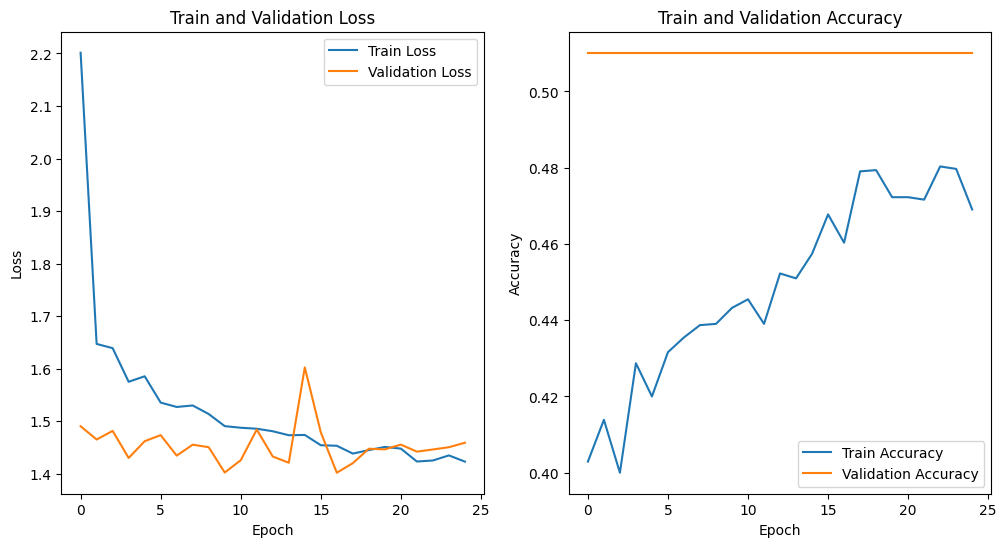

Final Accuracy: 0.5101
Final F1 Score: 0.3447


In [ ]:
# 모델, 손실 함수, 옵티마이저 설정
model = ModalityTransformerWithCLSAndFramewisePrediction(embed_dim= 768, num_heads=8, num_layers=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# DataLoader 준비 (입력과 라벨을 묶어서 제공)
batch_size = 32
dataset = TensorDataset(audio_embeddings, encoded_labels_tensor)
train_size = int(0.9 * len(dataset))  # 90:10 비율로 학습/테스트 데이터 나눔
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# EarlyStopping 인스턴스 생성
early_stopping = EarlyStopping(patience=8)

# 성능 기록을 위한 리스트 초기화
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epoch_cnt = 0

# 학습 루프 (CLS 토큰 기반 감정 예측)
num_epochs = 30
for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0

    correct_preds, total_preds = 0, 0  # 매 에폭마다 초기화

    for batch_embeddings, batch_labels in train_loader:
        # 데이터를 GPU로 이동
        batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

        # batch_labels를 long 타입으로 변환
        batch_labels = batch_labels.long()

        # Forward pass: CLS 토큰을 통한 감정 예측
        cls_output = model(batch_embeddings, modality='audio')  # 오디오 모달리티에 맞게 조정

        # 손실 함수 계산
        loss = criterion(cls_output, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 정확도 계산
        _, predicted = torch.max(cls_output, 1)  # 가장 높은 확률을 가진 클래스를 예측
        correct_preds += (predicted == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    # 학습 손실 및 정확도 기록
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = correct_preds / total_preds
    train_accuracies.append(train_accuracy)

    # 예측값이 0~5 범위 내에 있는지 확인
    predicted_values = predicted.cpu().numpy()  # 예측된 클래스 값
    print(f"Epoch [{epoch+1}/{num_epochs}], Predicted Values: {predicted_values[:10]}")  # 첫 10개 예측값 출력
    print(f"Epoch [{epoch+1}/{num_epochs}], Actual Labels: {batch_labels.cpu().numpy()[:10]}")  # 첫 10개 실제 라벨 출력

    # 검증 단계
    model.eval()
    val_loss = 0
    correct_preds, total_preds = 0, 0  # 검증 단계에서 다시 초기화
    with torch.no_grad():
        for batch_embeddings, batch_labels in test_loader:
            batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

            # batch_labels를 long 타입으로 변환
            batch_labels = batch_labels.long()

            # Forward pass (검증)
            cls_output = model(batch_embeddings, modality='audio')  # 오디오 모달리티에 맞게 조정

            val_loss += criterion(cls_output, batch_labels).item()

            # 검증 정확도 계산
            _, predicted = torch.max(cls_output, 1)
            correct_preds += (predicted == batch_labels).sum().item()
            total_preds += batch_labels.size(0)

    # 검증 손실 및 정확도 기록
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    val_accuracy = correct_preds / total_preds
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    epoch_cnt += 1
    # Early stopping 체크
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

# 성능 시각화
plt.figure(figsize=(12, 6))

# 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy")
plt.legend()

plt.show()

# 성능 평가 루프 (CLS 토큰 기반 감정 예측 평가)
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_embeddings, batch_labels in test_loader:
        # 데이터를 GPU로 이동
        batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

        # batch_labels를 long 타입으로 변환
        batch_labels = batch_labels.long()

        # Forward pass (오디오 모달리티로 감정 예측)
        cls_output = model(batch_embeddings, modality='audio')

        # 예측값 predicted를 long 타입으로 변환
        _, predicted = torch.max(cls_output, 1)
        predicted = predicted.long()

        # GPU 텐서를 CPU로 이동하여 numpy로 변환
        all_preds.extend(predicted.cpu().numpy())  # GPU 텐서를 CPU로 변환 후 numpy로 변환
        all_labels.extend(batch_labels.cpu().numpy())  # 동일하게 처리

# 정확도 및 F1 점수 계산
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

# 모델 저장 (확장자 추가)
torch.save(model.state_dict(), file_path + f'/individual_modality_transformer_model/audio_epoch_{epoch_cnt}_acc_{accuracy:.3f}.pth')

print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final F1 Score: {f1:.4f}")

# 교차학습을 위한 오디오 임베딩 벡터 저장

In [ ]:
model.load_state_dict(torch.load(file_path + '/individual_modality_transformer_model/audio_epoch_25_acc_0.510.pth'))
model.eval()

<ipython-input-27-08cd9e972bae>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path + '/individual_modality_transformer_model/audio_e

ModalityTransformerWithCLSAndFramewisePrediction(
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=768, out_features=6, bias=True)
)

In [ ]:
# 오디오 데이터를 TensorDataset으로 묶기 (오디오 임베딩, 라벨 포함)
audio_dataset = TensorDataset(audio_embeddings, encoded_labels_tensor)

# DataLoader 생성 (배치 크기 32, 셔플 여부는 필요에 따라 설정)
audio_loader = DataLoader(audio_dataset, batch_size=32, shuffle=False, drop_last=True)

audio_embeddings = []

In [ ]:
# 드랍 last 설정으로 데이터 로더 일부 삭제
with torch.no_grad():
    for batch_embeddings, _ in audio_loader:  # 오디오 임베딩과 라벨 추출 (라벨은 사용하지 않음)
        batch_embeddings = batch_embeddings.to(device)

        # 모델에 오디오 임베딩 입력
        cls_output = model(batch_embeddings, modality='audio')  # CLS 토큰으로부터 임베딩 추출

        # CLS 토큰을 임베딩으로 사용
        audio_embeddings.append(cls_output.cpu().numpy())

# 리스트를 numpy 배열로 변환 (배치 차원 제거)
audio_embeddings = np.concatenate(audio_embeddings, axis=0)  # (전체 오디오 샘플 수, embed_dim)

# 임베딩 벡터 저장
np.save(file_path + '/contrastive_learning_input_embedding/audio_embeddings.npy', audio_embeddings)

print(f"오디오 임베딩 벡터가 {file_path}/contrastive_learning_input_embedding/에 저장되었습니다.")

# 저장된 오디오 임베딩 데이터를 불러오기
audio_embeddings = np.load(file_path + '/contrastive_learning_input_embedding/audio_embeddings.npy')

# 데이터의 형태를 확인
print(audio_embeddings.shape)  # (전체 오디오 샘플 수, embed_dim)

오디오 임베딩 벡터가 /content/drive/MyDrive/sns_multimodal_sentiment_pr/contrastive_learning_input_embedding/에 저장되었습니다.
(3424, 768)


# 텍스트 트랜스포머 아웃풋
## 텍스트는 버트 사용으로 포지셔널 임베딩 이미 돼있으므로 cls 토큰만 추가 오디오와 거의 대부분 동일

In [ ]:
# 텐서의 형태 확인
print(text_embeddings.shape)  # (103849, 768)
print(encoded_text_labels_tensor.shape)  # (103849,)

torch.Size([103849, 768])
torch.Size([103849])


In [ ]:
# 2. DataLoader 준비 (입력과 라벨을 묶어서 제공)
batch_size = 64
dataset = TensorDataset(text_embeddings, encoded_text_labels_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# 모델, 손실 함수, 옵티마이저 설정
model = ModalityTransformerWithCLSAndFramewisePrediction(embed_dim= 768, num_heads=12, num_layers=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# DataLoader 준비 (입력과 라벨을 묶어서 제공)
batch_size = 32
dataset = TensorDataset(text_embeddings, encoded_text_labels_tensor)
train_size = int(0.8 * len(dataset))  # 80:20 비율로 학습/테스트 데이터 나눔
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# EarlyStopping 인스턴스 생성
early_stopping = EarlyStopping(patience=15)

# 성능 기록을 위한 리스트 초기화
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epoch_cnt = 0

# 학습 루프 (CLS 토큰 기반 감정 예측)
num_epochs = 50
for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0

    correct_preds, total_preds = 0, 0  # 매 에폭마다 초기화

    for batch_embeddings, batch_labels in train_loader:
        # 데이터를 GPU로 이동
        batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

        # batch_labels를 long 타입으로 변환
        batch_labels = batch_labels.long()

        # Forward pass: CLS 토큰을 통한 감정 예측
        cls_output = model(batch_embeddings, modality='text')  # 텍스트 모달리티에 맞게 조정

        # 손실 함수 계산
        loss = criterion(cls_output, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 정확도 계산
        _, predicted = torch.max(cls_output, 1)  # 가장 높은 확률을 가진 클래스를 예측
        correct_preds += (predicted == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    # 학습 손실 및 정확도 기록
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = correct_preds / total_preds
    train_accuracies.append(train_accuracy)

    # 예측값이 0~5 범위 내에 있는지 확인
    predicted_values = predicted.cpu().numpy()  # 예측된 클래스 값
    print(f"Epoch [{epoch+1}/{num_epochs}], Predicted Values: {predicted_values[:10]}")  # 첫 10개 예측값 출력
    print(f"Epoch [{epoch+1}/{num_epochs}], Actual Labels: {batch_labels.cpu().numpy()[:10]}")  # 첫 10개 실제 라벨 출력

    # 검증 단계
    model.eval()
    val_loss = 0
    correct_preds, total_preds = 0, 0  # 검증 단계에서 다시 초기화
    with torch.no_grad():
        for batch_embeddings, batch_labels in test_loader:
            batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

            # batch_labels를 long 타입으로 변환
            batch_labels = batch_labels.long()

            # Forward pass (검증)
            cls_output = model(batch_embeddings, modality='text')  # 오디오 모달리티에 맞게 조정

            val_loss += criterion(cls_output, batch_labels).item()

            # 검증 정확도 계산
            _, predicted = torch.max(cls_output, 1)
            correct_preds += (predicted == batch_labels).sum().item()
            total_preds += batch_labels.size(0)

    # 검증 손실 및 정확도 기록
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    val_accuracy = correct_preds / total_preds
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    epoch_cnt += 1
    # Early stopping 체크
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

# 성능 시각화
plt.figure(figsize=(12, 6))

# 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy")
plt.legend()

plt.show()

# 성능 평가 루프 (CLS 토큰 기반 감정 예측 평가)
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_embeddings, batch_labels in test_loader:
        # 데이터를 GPU로 이동
        batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

        # batch_labels를 long 타입으로 변환
        batch_labels = batch_labels.long()

        # Forward pass (텍스트 모달리티로 감정 예측)
        cls_output = model(batch_embeddings, modality='text')

        # 예측값 predicted를 long 타입으로 변환
        _, predicted = torch.max(cls_output, 1)
        predicted = predicted.long()

        # GPU 텐서를 CPU로 이동하여 numpy로 변환
        all_preds.extend(predicted.cpu().numpy())  # GPU 텐서를 CPU로 변환 후 numpy로 변환
        all_labels.extend(batch_labels.cpu().numpy())  # 동일하게 처리

# 정확도 및 F1 점수 계산
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

# 모델 저장 (확장자 추가)
torch.save(model.state_dict(), file_path + f'/individual_modality_transformer_model/text_epoch_{epoch_cnt}_acc_{accuracy:.3f}.pth')

print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final F1 Score: {f1:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Predicted Values: [0 5 0 0 0 0 0]
Epoch [1/50], Actual Labels: [1 2 5 3 2 2 0]


  2%|▏         | 1/50 [01:28<1:12:30, 88.79s/it]

Epoch [1/50], Train Loss: 1.9246, Val Loss: 1.8158, Train Acc: 0.1779, Val Acc: 0.1865
Epoch [2/50], Predicted Values: [0 0 0 0 0 0 0]
Epoch [2/50], Actual Labels: [4 2 4 0 3 0 2]


  4%|▍         | 2/50 [02:56<1:10:33, 88.19s/it]

Epoch [2/50], Train Loss: 1.8478, Val Loss: 1.8445, Train Acc: 0.1782, Val Acc: 0.1865
Epoch [3/50], Predicted Values: [5 4 5 5 5 5 5]
Epoch [3/50], Actual Labels: [1 0 4 4 5 0 4]


  6%|▌         | 3/50 [04:24<1:08:57, 88.03s/it]

Epoch [3/50], Train Loss: 1.8326, Val Loss: 1.8337, Train Acc: 0.1781, Val Acc: 0.1865
Epoch [4/50], Predicted Values: [5 5 5 5 5 5 5]
Epoch [4/50], Actual Labels: [5 3 1 1 2 2 0]


  8%|▊         | 4/50 [05:52<1:07:34, 88.14s/it]

Epoch [4/50], Train Loss: 1.8213, Val Loss: 1.8106, Train Acc: 0.1822, Val Acc: 0.1962
Epoch [5/50], Predicted Values: [1 1 1 1 1 1 1]
Epoch [5/50], Actual Labels: [4 0 1 5 2 3 2]


 10%|█         | 5/50 [07:21<1:06:24, 88.54s/it]

Epoch [5/50], Train Loss: 1.8159, Val Loss: 1.8142, Train Acc: 0.1829, Val Acc: 0.1553


 10%|█         | 5/50 [08:05<1:12:47, 97.05s/it]


KeyboardInterrupt: 

# 교차학습을 위한 텍스트 임베딩 벡터 저장

In [ ]:
model.load_state_dict(torch.load(file_path + '/individual_modality_transformer_model/text_epoch_13_acc_0.188.pth'))
model.eval()

<ipython-input-59-9586cc6d3cb4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path + '/individual_modality_transformer_model/text_ep

ModalityTransformerWithCLSAndFramewisePrediction(
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=768, out_features=6, bias=True)
)

In [ ]:
# 텍스트 데이터를 TensorDataset으로 묶기 (텍스트 임베딩, 라벨 포함)
text_dataset = TensorDataset(text_embeddings, encoded_text_labels_tensor)

# DataLoader 생성 (배치 크기 32, 셔플 여부는 필요에 따라 설정)
text_loader = DataLoader(text_dataset, batch_size=32, shuffle=False, drop_last=True)

text_embeddings = []

In [ ]:
# 드랍 last 설정으로 데이터 로더 일부 삭제
with torch.no_grad():
    for batch_embeddings, _ in text_loader:  # 텍스트 임베딩과 라벨 추출 (라벨은 사용하지 않음)
        batch_embeddings = batch_embeddings.to(device)

        # 모델에 오디오 임베딩 입력
        cls_output = model(batch_embeddings, modality='text')  # CLS 토큰으로부터 임베딩 추출

        # CLS 토큰을 임베딩으로 사용
        text_embeddings.append(cls_output.cpu().numpy())

# 리스트를 numpy 배열로 변환 (배치 차원 제거)
text_embeddings = np.concatenate(text_embeddings, axis=0)  # (전체 텍스트 샘플 수, embed_dim)

# 임베딩 벡터 저장
np.save(file_path + '/contrastive_learning_input_embedding/text_embeddings.npy', text_embeddings)

print(f"텍스트 임베딩 벡터가 {file_path}/contrastive_learning_input_embedding/에 저장되었습니다.")

# 저장된 텍스트 임베딩 데이터를 불러오기
text_embeddings = np.load(file_path + '/contrastive_learning_input_embedding/text_embeddings.npy')

# 데이터의 형태를 확인
print(text_embeddings.shape)  # (전체 텍스트 샘플 수, embed_dim)

텍스트 임베딩 벡터가 /content/drive/MyDrive/sns_multimodal_sentiment_pr/contrastive_learning_input_embedding/에 저장되었습니다.
(103840, 768)


# 이미지 트랜스포머 아웃풋
## 이미지는 포지셔널 임베딩 + cls 토큰 추가 진행

In [ ]:
# 텐서의 형태 확인
print(image_embeddings.shape)  # (103849, 768)
print(encoded_image_labels_tensor.shape)  # (103849,)

torch.Size([1980, 768])
torch.Size([1980])


In [ ]:
# 2. DataLoader 준비 (입력과 라벨을 묶어서 제공)
batch_size = 32
dataset = TensorDataset(image_embeddings, encoded_image_labels_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  3%|▎         | 1/30 [00:01<00:39,  1.37s/it]

Epoch [1/30], Predicted Values: [1 0 5 4 4 1 1 1 3 5]
Epoch [1/30], Actual Labels: [0 5 1 1 1 1 1 5 1 3]
Epoch [1/30], Train Loss: 2.9852, Val Loss: 1.8695, Train Acc: 0.1538, Val Acc: 0.1869


  7%|▋         | 2/30 [00:02<00:38,  1.37s/it]

Epoch [2/30], Predicted Values: [4 4 0 1 3 3 1 5 4 1]
Epoch [2/30], Actual Labels: [4 2 4 4 0 3 2 0 2 5]
Epoch [2/30], Train Loss: 2.2015, Val Loss: 1.8988, Train Acc: 0.1751, Val Acc: 0.1869


 10%|█         | 3/30 [00:04<00:37,  1.38s/it]

Epoch [3/30], Predicted Values: [3 3 2 2 2 2 2 2 2 2]
Epoch [3/30], Actual Labels: [5 4 2 4 0 2 2 4 4 3]
Epoch [3/30], Train Loss: 2.1715, Val Loss: 1.9063, Train Acc: 0.1627, Val Acc: 0.1717


 13%|█▎        | 4/30 [00:05<00:35,  1.37s/it]

Epoch [4/30], Predicted Values: [1 5 1 5 3 0 4 4 1 0]
Epoch [4/30], Actual Labels: [2 5 5 4 2 1 0 1 3 4]
Epoch [4/30], Train Loss: 2.0945, Val Loss: 1.8463, Train Acc: 0.1734, Val Acc: 0.1616


 17%|█▋        | 5/30 [00:06<00:34,  1.36s/it]

Epoch [5/30], Predicted Values: [0 4 0 5 3 1 4 1 4 4]
Epoch [5/30], Actual Labels: [5 3 0 3 2 1 1 3 4 0]
Epoch [5/30], Train Loss: 2.1341, Val Loss: 1.8682, Train Acc: 0.1392, Val Acc: 0.1869


 20%|██        | 6/30 [00:08<00:32,  1.36s/it]

Epoch [6/30], Predicted Values: [0 1 4 0 4 4 4 0 4 2]
Epoch [6/30], Actual Labels: [5 0 4 1 2 0 3 4 2 4]
Epoch [6/30], Train Loss: 2.0975, Val Loss: 1.8501, Train Acc: 0.1605, Val Acc: 0.1616


 23%|██▎       | 7/30 [00:09<00:31,  1.37s/it]

Epoch [7/30], Predicted Values: [3 5 0 5 3 3 3 5 5 3]
Epoch [7/30], Actual Labels: [5 4 2 2 4 0 4 0 2 4]
Epoch [7/30], Train Loss: 2.1105, Val Loss: 1.8722, Train Acc: 0.1605, Val Acc: 0.1515


 27%|██▋       | 8/30 [00:11<00:30,  1.40s/it]

Epoch [8/30], Predicted Values: [3 3 3 1 2 2 4 4 3 3]
Epoch [8/30], Actual Labels: [1 5 2 2 0 2 1 1 2 1]
Epoch [8/30], Train Loss: 2.0760, Val Loss: 1.8496, Train Acc: 0.1672, Val Acc: 0.1515


 30%|███       | 9/30 [00:12<00:29,  1.38s/it]

Epoch [9/30], Predicted Values: [0 0 2 5 5 1 5 1 2 0]
Epoch [9/30], Actual Labels: [2 1 4 3 3 1 5 0 2 4]
Epoch [9/30], Train Loss: 2.0498, Val Loss: 1.8245, Train Acc: 0.1813, Val Acc: 0.1869


 33%|███▎      | 10/30 [00:13<00:27,  1.38s/it]

Epoch [10/30], Predicted Values: [1 1 1 4 1 1 4 1 4 5]
Epoch [10/30], Actual Labels: [0 0 0 5 5 0 0 5 5 2]
Epoch [10/30], Train Loss: 2.0246, Val Loss: 1.8313, Train Acc: 0.1773, Val Acc: 0.1616


 37%|███▋      | 11/30 [00:15<00:26,  1.39s/it]

Epoch [11/30], Predicted Values: [0 2 1 3 2 3 2 3 1 1]
Epoch [11/30], Actual Labels: [2 2 2 0 1 5 2 5 2 3]
Epoch [11/30], Train Loss: 2.0388, Val Loss: 1.8481, Train Acc: 0.1633, Val Acc: 0.1515


 40%|████      | 12/30 [00:16<00:24,  1.37s/it]

Epoch [12/30], Predicted Values: [0 4 2 4 0 1 2 1 1 1]
Epoch [12/30], Actual Labels: [2 4 5 0 4 3 4 2 1 2]
Epoch [12/30], Train Loss: 2.0216, Val Loss: 1.8310, Train Acc: 0.1785, Val Acc: 0.1869


 43%|████▎     | 13/30 [00:17<00:23,  1.39s/it]

Epoch [13/30], Predicted Values: [5 5 0 4 5 5 5 4 4 4]
Epoch [13/30], Actual Labels: [1 5 4 0 1 1 3 4 3 3]
Epoch [13/30], Train Loss: 2.0022, Val Loss: 1.8523, Train Acc: 0.1785, Val Acc: 0.1616


 47%|████▋     | 14/30 [00:19<00:22,  1.38s/it]

Epoch [14/30], Predicted Values: [1 5 2 4 2 2 5 1 5 4]
Epoch [14/30], Actual Labels: [0 2 3 0 2 3 1 5 4 2]
Epoch [14/30], Train Loss: 2.0003, Val Loss: 1.8273, Train Acc: 0.1678, Val Acc: 0.1667


 50%|█████     | 15/30 [00:20<00:20,  1.39s/it]

Epoch [15/30], Predicted Values: [0 4 1 0 1 0 0 0 0 4]
Epoch [15/30], Actual Labels: [5 5 2 2 1 3 0 4 4 3]
Epoch [15/30], Train Loss: 2.0224, Val Loss: 1.8274, Train Acc: 0.1762, Val Acc: 0.1616


 53%|█████▎    | 16/30 [00:22<00:19,  1.39s/it]

Epoch [16/30], Predicted Values: [3 1 1 0 1 1 0 0 5 1]
Epoch [16/30], Actual Labels: [4 4 1 0 1 3 0 4 5 3]
Epoch [16/30], Train Loss: 2.0081, Val Loss: 1.8266, Train Acc: 0.1751, Val Acc: 0.1869


 53%|█████▎    | 16/30 [00:23<00:20,  1.47s/it]

Epoch [17/30], Predicted Values: [5 4 1 0 5 4 1 0 0 4]
Epoch [17/30], Actual Labels: [5 4 0 5 5 3 4 4 0 2]
Epoch [17/30], Train Loss: 1.9903, Val Loss: 1.8261, Train Acc: 0.1470, Val Acc: 0.1616
Early stopping at epoch 17


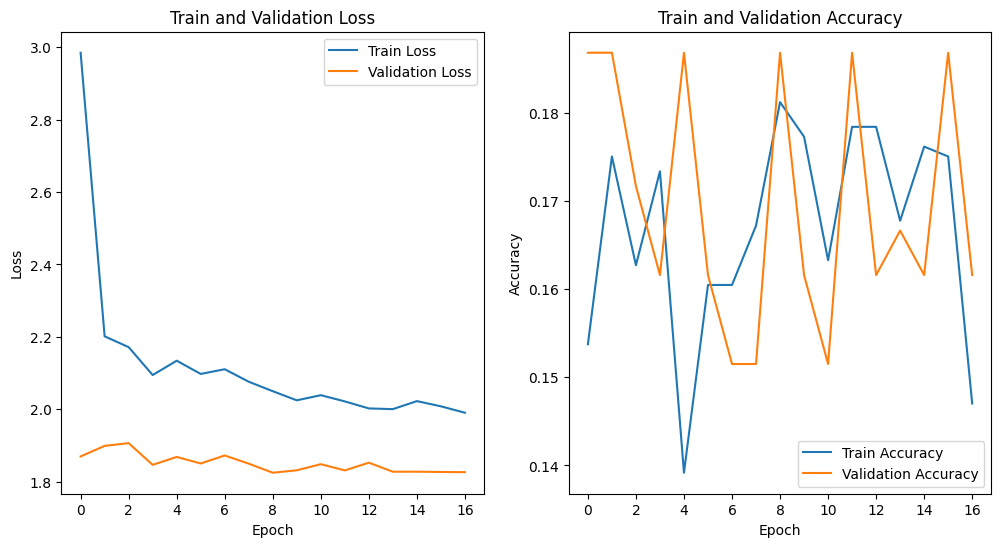

Final Accuracy: 0.1616
Final F1 Score: 0.0450


In [ ]:
# 모델, 손실 함수, 옵티마이저 설정
model = ModalityTransformerWithCLSAndFramewisePrediction(embed_dim=768, num_heads=8, num_layers=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# DataLoader 준비 (입력과 라벨을 묶어서 제공)
batch_size = 32
dataset = TensorDataset(image_embeddings, encoded_image_labels_tensor)  # 이미지 임베딩과 라벨로 데이터셋 구성
train_size = int(0.9 * len(dataset))  # 90:10 비율로 학습/테스트 데이터 나눔
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# EarlyStopping 인스턴스 생성
early_stopping = EarlyStopping(patience=8)

# 성능 기록을 위한 리스트 초기화
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epoch_cnt = 0

# 학습 루프 (CLS 토큰 기반 감정 예측)
num_epochs = 30
for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0

    correct_preds, total_preds = 0, 0  # 매 에폭마다 초기화

    for batch_embeddings, batch_labels in train_loader:
        # 데이터를 GPU로 이동
        batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

        # batch_labels를 long 타입으로 변환
        batch_labels = batch_labels.long()

        # Forward pass: CLS 토큰을 통한 감정 예측
        cls_output = model(batch_embeddings, modality='image')  # 이미지 모달리티에 맞게 조정

        # 손실 함수 계산
        loss = criterion(cls_output, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 정확도 계산
        _, predicted = torch.max(cls_output, 1)  # 가장 높은 확률을 가진 클래스를 예측
        correct_preds += (predicted == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    # 학습 손실 및 정확도 기록
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = correct_preds / total_preds
    train_accuracies.append(train_accuracy)

    # 예측값이 0~5 범위 내에 있는지 확인
    predicted_values = predicted.cpu().numpy()  # 예측된 클래스 값
    print(f"Epoch [{epoch+1}/{num_epochs}], Predicted Values: {predicted_values[:10]}")  # 첫 10개 예측값 출력
    print(f"Epoch [{epoch+1}/{num_epochs}], Actual Labels: {batch_labels.cpu().numpy()[:10]}")  # 첫 10개 실제 라벨 출력

    # 검증 단계
    model.eval()
    val_loss = 0
    correct_preds, total_preds = 0, 0  # 검증 단계에서 다시 초기화
    with torch.no_grad():
        for batch_embeddings, batch_labels in test_loader:
            batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

            # batch_labels를 long 타입으로 변환
            batch_labels = batch_labels.long()

            # Forward pass (검증)
            cls_output = model(batch_embeddings, modality='image')  # 이미지 모달리티에 맞게 조정

            val_loss += criterion(cls_output, batch_labels).item()

            # 검증 정확도 계산
            _, predicted = torch.max(cls_output, 1)
            correct_preds += (predicted == batch_labels).sum().item()
            total_preds += batch_labels.size(0)

    # 검증 손실 및 정확도 기록
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    val_accuracy = correct_preds / total_preds
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    epoch_cnt += 1
    # Early stopping 체크
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

# 성능 시각화
plt.figure(figsize=(12, 6))

# 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy")
plt.legend()

plt.show()

# 성능 평가 루프 (CLS 토큰 기반 감정 예측 평가)
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_embeddings, batch_labels in test_loader:
        # 데이터를 GPU로 이동
        batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

        # batch_labels를 long 타입으로 변환
        batch_labels = batch_labels.long()

        # Forward pass (이미지 모달리티로 감정 예측)
        cls_output = model(batch_embeddings, modality='image')

        # 예측값 predicted를 long 타입으로 변환
        _, predicted = torch.max(cls_output, 1)
        predicted = predicted.long()

        # GPU 텐서를 CPU로 이동하여 numpy로 변환
        all_preds.extend(predicted.cpu().numpy())  # GPU 텐서를 CPU로 변환 후 numpy로 변환
        all_labels.extend(batch_labels.cpu().numpy())  # 동일하게 처리

# 정확도 및 F1 점수 계산
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

# 모델 저장 (확장자 추가)
torch.save(model.state_dict(), file_path + f'/individual_modality_transformer_model/image_epoch_{epoch_cnt}_acc_{accuracy:.3f}.pth')

print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final F1 Score: {f1:.4f}")

교차학습을 위한 이미지 임베딩 벡터 생성

In [ ]:
model.load_state_dict(torch.load(file_path + '/individual_modality_transformer_model/image_epoch_17_acc_0.162.pth'))
model.eval()

<ipython-input-69-e122169715e6>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path + '/individual_modality_transformer_model/image_e

ModalityTransformerWithCLSAndFramewisePrediction(
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=768, out_features=6, bias=True)
)

In [ ]:
# 이미지 데이터를 TensorDataset으로 묶기 (이미지 임베딩, 라벨 포함)
image_dataset = TensorDataset(image_embeddings, encoded_image_labels_tensor)

# DataLoader 생성 (배치 크기 32, 셔플 여부는 필요에 따라 설정)
image_loader = DataLoader(image_dataset, batch_size=32, shuffle=False, drop_last=True)

image_embeddings = []

In [ ]:
# 드랍 last 설정으로 데이터 로더 일부 삭제
with torch.no_grad():
    for batch_embeddings, _ in image_loader:  # 텍스트 임베딩과 라벨 추출 (라벨은 사용하지 않음)
        batch_embeddings = batch_embeddings.to(device)

        # 모델에 오디오 임베딩 입력
        cls_output = model(batch_embeddings, modality='image')  # CLS 토큰으로부터 임베딩 추출

        # CLS 토큰을 임베딩으로 사용
        image_embeddings.append(cls_output.cpu().numpy())

# 리스트를 numpy 배열로 변환 (배치 차원 제거)
image_embeddings = np.concatenate(image_embeddings, axis=0)  # (전체 텍스트 샘플 수, embed_dim)

# 임베딩 벡터 저장
np.save(file_path + '/contrastive_learning_input_embedding/image_embeddings.npy', image_embeddings)

print(f"이미지 임베딩 벡터가 {file_path}/contrastive_learning_input_embedding/에 저장되었습니다.")

# 저장된 이미지 임베딩 데이터를 불러오기
image_embeddings = np.load(file_path + '/contrastive_learning_input_embedding/image_embeddings.npy')

# 데이터의 형태를 확인
print(image_embeddings.shape)  # (전체 이미지 샘플 수, embed_dim)

이미지 임베딩 벡터가 /content/drive/MyDrive/sns_multimodal_sentiment_pr/contrastive_learning_input_embedding/에 저장되었습니다.
(1952, 768)


#아래부터는 4가지 모달리티를 토대로 교차학습 진행 코드

## 모달리티 shape 확인

In [72]:
import numpy as np

In [73]:
# 저장된 비디오 임베딩 데이터를 불러오기
video_embeddings = np.load('/content/drive/MyDrive/sns_multimodal_sentiment_pr/contrastive_learning_input_embedding/video_embeddings.npy')
audio_embeddings = np.load('/content/drive/MyDrive/sns_multimodal_sentiment_pr/contrastive_learning_input_embedding/audio_embeddings.npy')
image_embeddings = np.load('/content/drive/MyDrive/sns_multimodal_sentiment_pr/contrastive_learning_input_embedding/image_embeddings.npy')
text_embeddings = np.load('/content/drive/MyDrive/sns_multimodal_sentiment_pr/contrastive_learning_input_embedding/text_embeddings.npy')

# 데이터의 형태를 확인 비디오 오디오 이미지 텍스트
print(video_embeddings.shape,audio_embeddings.shape,image_embeddings.shape,text_embeddings.shape)

(127, 4, 768) (3424, 768) (1952, 768) (103840, 768)


In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [75]:
# numpy 배열을 torch 텐서로 변환하는 함수
def numpy_to_tensor(data):
    return torch.from_numpy(data).float() if isinstance(data, np.ndarray) else data

In [76]:
# CrossModalProjection을 통한 비디오-오디오, 비디오-텍스트, 비디오-이미지 학습
class CrossModalProjection(nn.Module):
    def __init__(self, embed_dim=768, va_dim=512, vt_dim=256, vi_dim=256):
        super(CrossModalProjection, self).__init__()
        # 비디오-오디오 공통 공간 512차원으로 투영 (입력 크기 768, 출력 크기 512)
        self.video_to_va_proj = nn.Linear(embed_dim, va_dim)
        self.audio_to_va_proj = nn.Linear(embed_dim, va_dim)

        # 비디오-텍스트 공통 공간 256차원으로 투영 (입력 크기 768, 출력 크기 256)
        self.video_to_vt_proj = nn.Linear(embed_dim, vt_dim)
        self.text_to_vt_proj = nn.Linear(embed_dim, vt_dim)

        # 비디오-이미지 공통 공간 256차원으로 투영 (입력 크기 768, 출력 크기 256)
        self.video_to_vi_proj = nn.Linear(embed_dim, vi_dim)
        self.image_to_vi_proj = nn.Linear(embed_dim, vi_dim)

    def forward(self, video_embed, audio_embed, text_embed, image_embed):
        # 모든 입력을 torch 텐서로 변환
        video_embed = numpy_to_tensor(video_embed)
        audio_embed = numpy_to_tensor(audio_embed)
        text_embed = numpy_to_tensor(text_embed)
        image_embed = numpy_to_tensor(image_embed)

        # video_embed의 차원: (batch_size, num_frames, embedding_dim) = (127, 4, 768)
        batch_size, num_frames, embedding_dim = video_embed.size()

        # 비디오 임베딩을 프레임 단위로 처리 (배치 크기 * 프레임 수로 reshape)
        video_framewise = video_embed.view(batch_size * num_frames, embedding_dim)  # (127*4, 768)

        # 각 프레임별로 비디오를 다른 모달리티에 맞춰 투영
        video_va = self.video_to_va_proj(video_framewise)
        video_vt = self.video_to_vt_proj(video_framewise)
        video_vi = self.video_to_vi_proj(video_framewise)

        # 오디오, 텍스트, 이미지 모달리티에 대한 투영 (차원: (batch_size, embedding_dim))
        audio_va = self.audio_to_va_proj(audio_embed)
        text_vt = self.text_to_vt_proj(text_embed)
        image_vi = self.image_to_vi_proj(image_embed)


        # 비디오 프레임별 결과를 다시 (batch_size, num_frames, -1)로 reshape
        video_va = video_va.view(batch_size, num_frames, -1)  # (127, 4, 512)
        video_vt = video_vt.view(batch_size, num_frames, -1)  # (127, 4, 256)
        video_vi = video_vi.view(batch_size, num_frames, -1)  # (127, 4, 256)

        # 오디오, 텍스트, 이미지의 차원을 맞추기 위한 reshape (batch_size, 1, -1)
        audio_va = audio_va.unsqueeze(1)  # (3444, 1, 512)
        text_vt = text_vt.unsqueeze(1)    # (3444, 1, 256)
        image_vi = image_vi.unsqueeze(1)  # (3444, 1, 256)

        return video_va, audio_va, video_vt, text_vt, video_vi, image_vi

In [77]:
# Multiple Instance Learning NCE Loss (MIL-NCE)
class MIL_NCE_Loss(nn.Module):
    def __init__(self, temperature=0.07):
        super(MIL_NCE_Loss, self).__init__()
        self.temperature = temperature

    def forward(self, video_embed, other_embed, top_k=5):
        # 코사인 유사도 계산 (비디오-오디오/텍스트/이미지 간)
        sim_matrix = F.cosine_similarity(video_embed.unsqueeze(1), other_embed.unsqueeze(0), dim=-1)

        # 각 비디오 클립에 대해 가장 가까운 모달리티 클립 5개 샘플링 (positive pair로 간주)
        top_k_indices = torch.topk(sim_matrix, top_k, dim=1).indices

        # positive pair의 유사도 값 추출
        pos_pairs = sim_matrix.gather(1, top_k_indices)

        # NCE Loss 계산 (Noise Contrastive Estimation)
        nce_loss = -F.log_softmax(sim_matrix / self.temperature, dim=1).gather(1, top_k_indices).mean()

        return nce_loss


In [78]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, verbose=False):
        """
        patience (int): 개선이 없을 때 학습을 멈추기 전에 기다리는 에폭 수
        delta (float): 손실이 감소했다고 간주하기 위한 최소 변화량
        verbose (bool): True일 경우 개선 시 출력
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [79]:
# 학습 준비 (배치 처리 적용)
def train_model(num_epochs, video_embeddings, audio_embeddings, text_embeddings, image_embeddings, model, mil_nce_loss_fn, optimizer, early_stopping, batch_size=8):
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # numpy 배열을 torch 텐서로 변환 (배치 단위 처리 전에 변환)
        video_embeddings = numpy_to_tensor(video_embeddings)
        audio_embeddings = numpy_to_tensor(audio_embeddings)
        text_embeddings = numpy_to_tensor(text_embeddings)
        image_embeddings = numpy_to_tensor(image_embeddings)

        for i in range(0, video_embeddings.shape[0], batch_size):
            video_batch = video_embeddings[i:i+batch_size]
            audio_batch = audio_embeddings[i:i+batch_size]
            text_batch = text_embeddings[i:i+batch_size]
            image_batch = image_embeddings[i:i+batch_size]

            video_va, audio_va, video_vt, text_vt, video_vi, image_vi = model(
                video_batch, audio_batch, text_batch, image_batch
            )

            nce_loss_va = mil_nce_loss_fn(video_va, audio_va)
            nce_loss_vt = mil_nce_loss_fn(video_vt, text_vt)
            nce_loss_vi = mil_nce_loss_fn(video_vi, image_vi)

            total_loss = nce_loss_va + nce_loss_vt + nce_loss_vi
            total_loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Total NCE Loss: {total_loss.item():.4f}")

        early_stopping(total_loss)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

# 평가 준비 (배치 처리 적용)
def evaluate_model(video_embeddings, audio_embeddings, text_embeddings, image_embeddings, model, mil_nce_loss_fn, batch_size=8):
    model.eval()

    # numpy 배열을 torch 텐서로 변환 (평가 전에 변환)
    video_embeddings = numpy_to_tensor(video_embeddings)
    audio_embeddings = numpy_to_tensor(audio_embeddings)
    text_embeddings = numpy_to_tensor(text_embeddings)
    image_embeddings = numpy_to_tensor(image_embeddings)

    total_nce_loss = 0
    with torch.no_grad():
        for i in range(0, video_embeddings.shape[0], batch_size):
            video_batch = video_embeddings[i:i+batch_size]
            audio_batch = audio_embeddings[i:i+batch_size]
            text_batch = text_embeddings[i:i+batch_size]
            image_batch = image_embeddings[i:i+batch_size]

            video_va, audio_va, video_vt, text_vt, video_vi, image_vi = model(
                video_batch, audio_batch, text_batch, image_batch
            )

            nce_loss_va = mil_nce_loss_fn(video_va, audio_va)
            nce_loss_vt = mil_nce_loss_fn(video_vt, text_vt)
            nce_loss_vi = mil_nce_loss_fn(video_vi, image_vi)

            total_nce_loss += nce_loss_va + nce_loss_vt + nce_loss_vi

    print(f"Evaluation - Total NCE Loss: {total_nce_loss.item():.4f}")

# 교차학습 진행

In [89]:
# 모델 및 손실 함수 생성
model = CrossModalProjection(embed_dim=768, va_dim=512, vt_dim=256, vi_dim=256)
mil_nce_loss_fn = MIL_NCE_Loss(temperature=0.07)

# EarlyStopping 인스턴스 생성
early_stopping = EarlyStopping(patience=5, verbose=True)

# 옵티마이저 설정
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# 학습 실행
train_model(num_epochs=50, video_embeddings=video_embeddings, audio_embeddings=audio_embeddings, text_embeddings=text_embeddings, image_embeddings=image_embeddings, model=model, mil_nce_loss_fn=mil_nce_loss_fn, optimizer=optimizer, early_stopping=early_stopping, batch_size=8)

# 학습 후 평가 실행
evaluate_model(video_embeddings, audio_embeddings, text_embeddings, image_embeddings, model, mil_nce_loss_fn, batch_size=8)


Epoch [1/50], Total NCE Loss: 6.2383
Epoch [2/50], Total NCE Loss: 6.2383
Epoch [3/50], Total NCE Loss: 6.2383
Epoch [4/50], Total NCE Loss: 6.2383
EarlyStopping counter: 1 out of 5
Epoch [5/50], Total NCE Loss: 6.2383
Epoch [6/50], Total NCE Loss: 6.2383
EarlyStopping counter: 1 out of 5
Epoch [7/50], Total NCE Loss: 6.2383
Epoch [8/50], Total NCE Loss: 6.2383
EarlyStopping counter: 1 out of 5
Epoch [9/50], Total NCE Loss: 6.2383
EarlyStopping counter: 2 out of 5
Epoch [10/50], Total NCE Loss: 6.2383
EarlyStopping counter: 3 out of 5
Epoch [11/50], Total NCE Loss: 6.2383
EarlyStopping counter: 4 out of 5
Epoch [12/50], Total NCE Loss: 6.2383
EarlyStopping counter: 5 out of 5
Early stopping at epoch 12
Evaluation - Total NCE Loss: 99.8132


# 모델전과 모델 후의 임베딩 공간 차이를 보았을 떄 확실한 성능 차이를 보인다

#다음은 챗지피티의 분선결과

비디오 임베딩:
768차원에서 값의 범위가 -3.16에서 3.20으로 변동성이 있습니다.
공통 공간으로 투영되면서 범위가 축소되고, 값의 분포가 더 안정적으로 변했습니다.
오디오 임베딩:
13.20이라는 매우 높은 값이 있었으며, 이는 공통 공간으로 투영되면서 1.60 범위로 축소되었습니다.
공통 공간으로의 투영이 오디오 임베딩을 안정화시켰습니다.
텍스트 임베딩:
12.12로 값이 컸으나, 공통 공간으로 투영 후 2.05 범위로 축소되었습니다.
이는 모델이 텍스트 정보를 잘 변환하고 있는 신호입니다.
이미지 임베딩:
10.46이라는 큰 값에서 5.26으로 축소되었습니다. 공통 공간에 들어오면서 값의 분포가 축소되었지만, 여전히 다른 모달리티에 비해 값의 범위가 큽니다.
성능 분석:
값의 안정성 향상: 모델 통과 후 모든 모달리티 임베딩 값의 범위가 더 균형적으로 축소되었으며, 특히 오디오와 텍스트 모달리티에서 값의 범위가 큰 폭으로 줄어들어 모델의 안정성이 향상되었습니다.

공통 공간에서 차원 축소: 비디오와 오디오 임베딩이 768차원에서 512차원으로, 텍스트와 이미지 임베딩은 768차원에서 256차원으로 차원 축소가 이루어졌습니다. 이는 모달리티 간 유사성을 더 쉽게 계산할 수 있게 합니다.

문제점:
이미지 임베딩의 값의 범위: 이미지 임베딩의 값이 다른 모달리티에 비해 여전히 큰 범위를 가지고 있어, 모델 학습 시 일부 영향을 줄 수 있습니다. 이는 정규화 등의 추가 처리가 필요할 수 있습니다.
결론:
성능의 진전은 명확히 확인되었습니다. 모델이 공통 공간으로 임베딩을 투영하면서 값의 분포가 더 안정화되었고, 모달리티 간 관계를 학습할 수 있는 환경이 잘 구축되었습니다.
그러나, 이미지 임베딩의 값의 범위가 다른 모달리티에 비해 상대적으로 크기 때문에, 추가적인 정규화나 스케일링 작업이 필요할 수 있습니다.

In [90]:
# 임베딩의 크기와 값 분포를 확인하는 함수 (의미와 함께 출력)
def check_embeddings_with_meaning(embeddings):
    """
    각 임베딩의 shape과 값 분포(최소값/최대값)를 출력하며, 해당 임베딩이 무엇을 나타내는지 설명.
    :param embeddings: 여러 개의 임베딩 텐서 (video_va, audio_va 등)
    """
    meanings = [
        "video_embeddings: 비디오 임베딩 (768차원)",
        "audio_embeddings: 오디오 임베딩 (768차원)",
        "text_embeddings: 텍스트 임베딩 (768차원)",
        "image_embeddings: 이미지 임베딩 (768차원)"
    ]

    for i, (embedding, meaning) in enumerate(zip(embeddings, meanings)):
        shape = embedding.shape
        min_val = embedding.min().item()
        max_val = embedding.max().item()
        print(f"{meaning}")
        print(f"  Embedding {i+1} - Shape: {shape}, Min: {min_val}, Max: {max_val}\n")

# 모델 통과 전후의 임베딩 크기 및 분포 비교
def evaluate_and_compare_embeddings_with_meaning(video_embeddings, audio_embeddings, text_embeddings, image_embeddings, model):
    """
    모델 활용 전후의 각 모달리티 임베딩의 크기와 값 분포를 비교하고, 그 의미를 설명하는 함수.
    """
    # numpy 배열을 torch 텐서로 변환
    video_embeddings_t = numpy_to_tensor(video_embeddings)
    audio_embeddings_t = numpy_to_tensor(audio_embeddings)
    text_embeddings_t = numpy_to_tensor(text_embeddings)
    image_embeddings_t = numpy_to_tensor(image_embeddings)

    # 모델 통과 전 임베딩 확인
    print("\n모델 통과 전 임베딩 상태:")
    check_embeddings_with_meaning([video_embeddings_t, audio_embeddings_t, text_embeddings_t, image_embeddings_t])

    model.eval()

    with torch.no_grad():
        # 모델에 텐서로 변환된 임베딩을 전달
        video_va, audio_va, video_vt, text_vt, video_vi, image_vi = model(
            video_embeddings_t, audio_embeddings_t, text_embeddings_t, image_embeddings_t
        )

    # 모델 통과 후 임베딩 확인
    print("\n모델 통과 후 임베딩 상태:")
    check_embeddings_with_meaning([video_va, audio_va, video_vt, text_vt, video_vi, image_vi])

# 시각화 및 확인 함수 실행
evaluate_and_compare_embeddings_with_meaning(video_embeddings, audio_embeddings, text_embeddings, image_embeddings, model)


모델 통과 전 임베딩 상태:
video_embeddings: 비디오 임베딩 (768차원)
  Embedding 1 - Shape: torch.Size([127, 4, 768]), Min: -3.16660213470459, Max: 3.2009053230285645

audio_embeddings: 오디오 임베딩 (768차원)
  Embedding 2 - Shape: torch.Size([3424, 768]), Min: -1.2942382097244263, Max: 13.200847625732422

text_embeddings: 텍스트 임베딩 (768차원)
  Embedding 3 - Shape: torch.Size([103840, 768]), Min: -3.14351749420166, Max: 12.128424644470215

image_embeddings: 이미지 임베딩 (768차원)
  Embedding 4 - Shape: torch.Size([1952, 768]), Min: -1.5404974222183228, Max: 10.462053298950195


모델 통과 후 임베딩 상태:
video_embeddings: 비디오 임베딩 (768차원)
  Embedding 1 - Shape: torch.Size([127, 4, 512]), Min: -2.2084031105041504, Max: 1.6030035018920898

audio_embeddings: 오디오 임베딩 (768차원)
  Embedding 2 - Shape: torch.Size([3424, 1, 512]), Min: -1.7097883224487305, Max: 1.6891177892684937

text_embeddings: 텍스트 임베딩 (768차원)
  Embedding 3 - Shape: torch.Size([127, 4, 256]), Min: -1.7304847240447998, Max: 1.4999186992645264

image_embeddings: 이미지 임베딩 (768

#  poc 결론
 ### 1.교차학습은 전혀 진행되지 않았다.
 ### 2.저차원 공간에 투영한것만으로 임베딩 값들이 정돈되는 효과 (이미지는 상대적으로 덜 효과) 실제 감정 분류를 해봐야 성능 확인 될 듯
 ### 3.데이터셋 정돈해서 다시 학습 진행이 필요할 듯하다
 ### 4.라벨이 없는 교차 학습 과정에서 성능 테스트할 방법 구축 필요(poc에서는 임베딩값과 nce_loss만으로 성능을 평가했는데 실제 데이터로 감정 분류 성능 데스트가 필요할 듯)  
  




# 개선점
## > 비디오
### 문제점: 비디오 클립단위로 하니 오히려 다른 모달리티보다도 개수가 너무 부족하다.
### 해결 방법: 클립단위가 아닌 프레임단위로 임베딩함으로써 데이터를 늘리고
### cls와 포지셔널 임베딩만으로 시간정보 기억하게 하는식으로 다시 코드 수정

## > 오디오
### 문제점: 트랜스포머 처리 과정에서부터 학습 불균형으로 좋은 성능을 뽑지 못하고 데이터 개수도 부족
### 해결 방법: 데이터를 증강하고 감정 재분류로 트랜스포머 성능 증강

## > 이미지
### 문제점: 데이터 개수가 적어 트랜스포머 처리 과정에서 좋지 못한 성능
### 해결 방법: 데이터 증강으로 트랜스포머 성능 증강

## > 텍스트
### 문제점: 데이터 개수는 충분하나 잘 분류되지 못하여 트랜스포머 처리과정에서 좋지 못한 성능
### 해결 방법: 데이터 전처리로 트랜스포머 성능 증강
